In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch

#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

import gensim
from gensim.models import Word2Vec

tqdm.pandas(desc='Progress')
from collections import Counter

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os 

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Basic Parameters

In [3]:
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 750 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

Import Datasets

In [4]:
data1 = pd.read_csv('drive/MyDrive/Web Search/drugsComTrain_raw.csv')
data2 = pd.read_csv('drive/MyDrive/Web Search/drugsComTest_raw.csv')

data = pd.concat([data1,data2])[['review','condition', 'drugName']]

In [5]:
data1 = data1[pd.notnull(data1['review'])]
data2 = data2[pd.notnull(data2['review'])]

In [6]:
data1 = data1.drop_duplicates(subset=['review'])
data2 = data2.drop_duplicates(subset=['review'])

In [7]:
data1['len'] = data1['review'].apply(lambda s : len(s))
data2['len'] = data2['review'].apply(lambda s : len(s))

<ipython-input-7-1fec94502b40>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['len'] = data2['review'].apply(lambda s : len(s))


<Axes: ylabel='Frequency'>

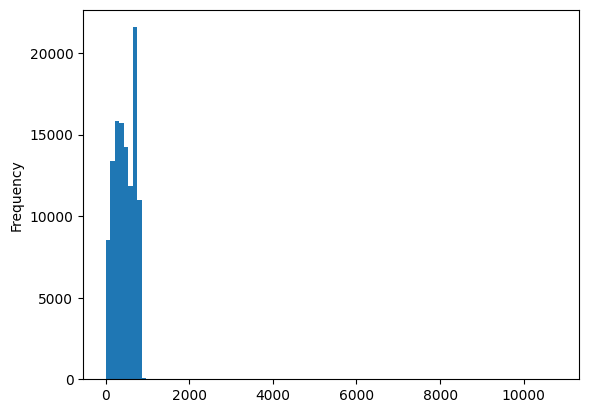

In [8]:
data1['len'].plot.hist(bins=100)

<Axes: ylabel='Frequency'>

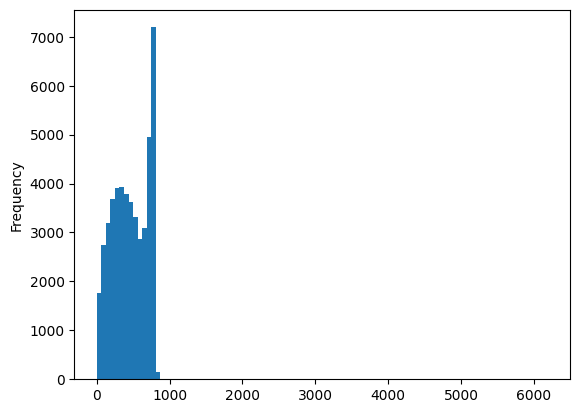

In [9]:
data2['len'].plot.hist(bins=100)

In [10]:
count_df1 = data1[['condition','review']].groupby('condition').aggregate({'review':'count'}).reset_index().sort_values('review',ascending=False)
count_df1.head()

,condition,review
150,Birth Control,18130
247,Depression,6281
578,Pain,4433
110,Anxiety,4324
65,Acne,3952


In [11]:
count_df2 = data2[['condition','review']].groupby('condition').aggregate({'review':'count'}).reset_index().sort_values('review',ascending=False)
count_df2.head()

,condition,review
120,Birth Control,8402
199,Depression,2798
476,Pain,1895
85,Anxiety,1745
48,Acne,1693


In [12]:
target_conditions1 = count_df1[count_df1['review']>1000]['condition'].values
target_conditions2 = count_df2[count_df2['review']>1000]['condition'].values

In [13]:
len(target_conditions1)

25

In [14]:
len(target_conditions2)

9

In [15]:
def condition_parser1(x):
    if x in target_conditions1:
        return x
    else:
        return "OTHER"
    
data1['condition'] = data1['condition'].apply(lambda x: condition_parser1(x)) 

In [16]:
def condition_parser2(x):
    if x in target_conditions2:
        return x
    else:
        return "OTHER"
    
data2['condition'] = data2['condition'].apply(lambda x: condition_parser2(x)) 

In [17]:
data1 = data1[data1['condition']!='OTHER']
data2 = data2[data2['condition']!='OTHER']

In [18]:
# fin_text = data

In [19]:
import plotly.express as px
px.bar(count_df1[count_df1['review']>1000],x='condition',y='review')


In [20]:
import re

def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', ' ', x)
        x = re.sub('[0-9]{4}', ' ', x)
        x = re.sub('[0-9]{3}', ' ', x)
        x = re.sub('[0-9]{2}', ' ', x)
        x = re.sub(r'[^\w\s]', '', x)
    return x

# Load the stop words
stop_words = set(stopwords.words('english'))

symbol_pattern = re.compile('[^\w\s]+')

# Define a function to remove stop words from a text
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [21]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)
# Usage
replace_contractions("this's a text with contraction")

'this is a text with contraction'

In [22]:
# lower the text
data1["review"] = data1["review"].apply(lambda x: x.lower())
data2["review"] = data2["review"].apply(lambda x: x.lower())

# Clean the text
data1["review"] = data1["review"].apply(lambda x: clean_text(x))
data2["review"] = data2["review"].apply(lambda x: x.lower())

# Clean numbers
data1["review"] = data1["review"].apply(lambda x: clean_numbers(x))
data2["review"] = data2["review"].apply(lambda x: x.lower())

# Clean Contractions
data1["review"] = data1["review"].apply(lambda x: replace_contractions(x))
data2["review"] = data2["review"].apply(lambda x: x.lower())

data1['review'] = data1['review'].apply(remove_stopwords)
data2["review"] = data2["review"].apply(lambda x: x.lower())

data1['review'] = data1['review'].str.replace(symbol_pattern, ' ')
data2["review"] = data2["review"].apply(lambda x: x.lower())

In [23]:
sentences = [sentence.split() for sentence in data1['review']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)


In [24]:
# from sklearn.model_selection import train_test_split
# train_X, test_X, train_y, test_y = train_test_split(data['review'], data['condition'],
#                                                     stratify=data['condition'], 
#                                                     test_size=0.25, 
#                                                     random_state=42)


In [25]:
train_X, test_X, train_y, test_y = data1['review'], data2['review'], data1['condition'], data2['condition']

In [26]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)
print("Train shape : ",train_y.shape)
print("Test shape : ",test_y.shape)

Train shape :  (69931,)
Test shape :  (21081,)
Train shape :  (69931,)
Test shape :  (21081,)


In [27]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [28]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)


In [29]:
def load_glove(word_index):
    EMBEDDING_FILE = '/content/drive/MyDrive/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [30]:
if debug:
    embedding_matrix = np.random.randn(120000,300)
else:
    embedding_matrix = load_glove(tokenizer.word_index)

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



In [31]:
np.shape(embedding_matrix)

(49786, 300)

In [32]:
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,5]
        num_filters = 36
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit

In [33]:
n_epochs = 10
model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

<ipython-input-33-f01aef079cf9>:48: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch 1/10 	 loss=807.3578 	 val_loss=359.9772  	 val_acc=0.8161  	 time=35.97s
Epoch 2/10 	 loss=420.0249 	 val_loss=304.4813  	 val_acc=0.8304  	 time=36.19s
Epoch 3/10 	 loss=366.2656 	 val_loss=274.7246  	 val_acc=0.8377  	 time=37.53s
Epoch 4/10 	 loss=341.0459 	 val_loss=262.8632  	 val_acc=0.8405  	 time=37.09s
Epoch 5/10 	 loss=321.5603 	 val_loss=253.8853  	 val_acc=0.8451  	 time=37.66s
Epoch 6/10 	 loss=305.3120 	 val_loss=247.9867  	 val_acc=0.8492  	 time=37.18s
Epoch 7/10 	 loss=292.3939 	 val_loss=250.4550  	 val_acc=0.8486  	 time=37.22s
Epoch 8/10 	 loss=279.8850 	 val_loss=242.0971  	 val_acc=0.8502  	 time=37.27s
Epoch 9/10 	 loss=268.3383 	 val_loss=242.6549  	 val_acc=0.8466  	 time=37.21s
Epoch 10/10 	 loss=259.7921 	 val_loss=242.2144  	 val_acc=0.8458  	 time=37.15s


In [34]:
torch.save(model,'textcnn_model')

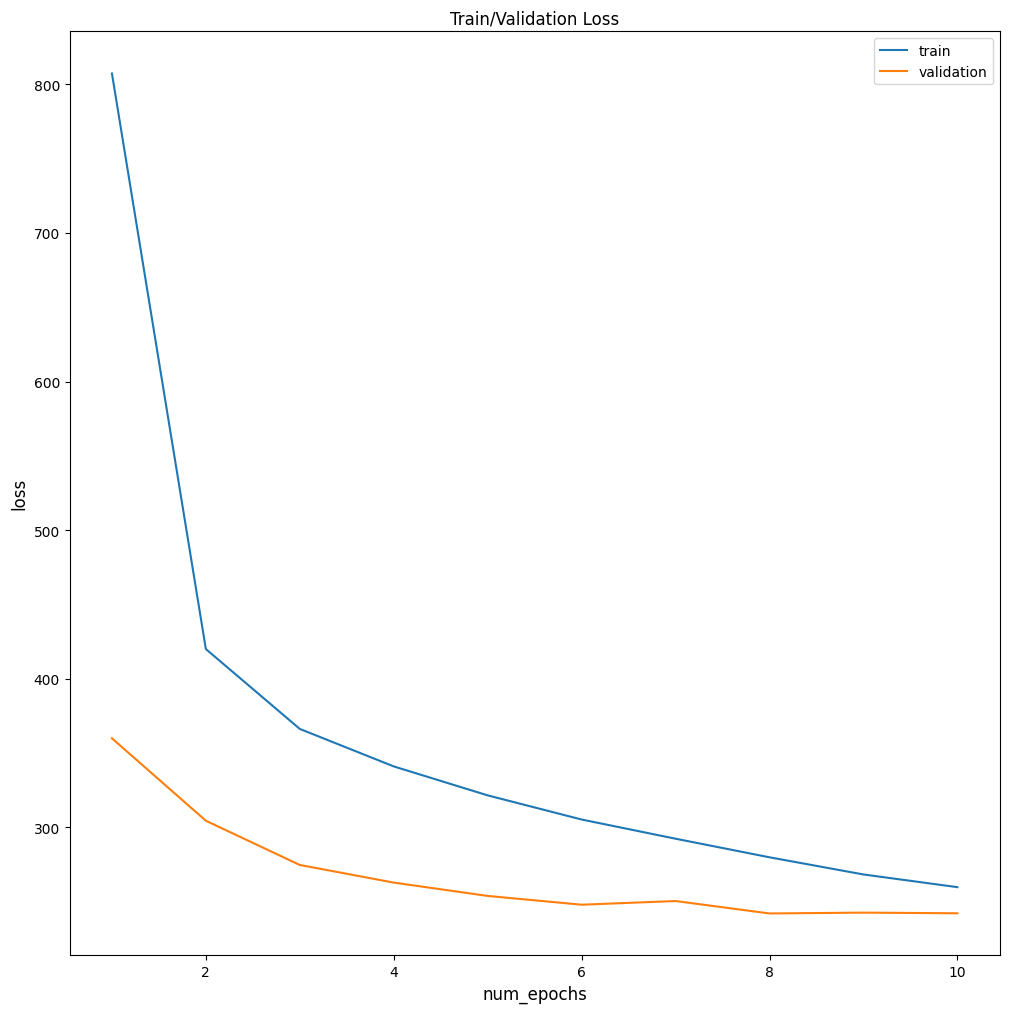

In [35]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
plot_graph(n_epochs)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

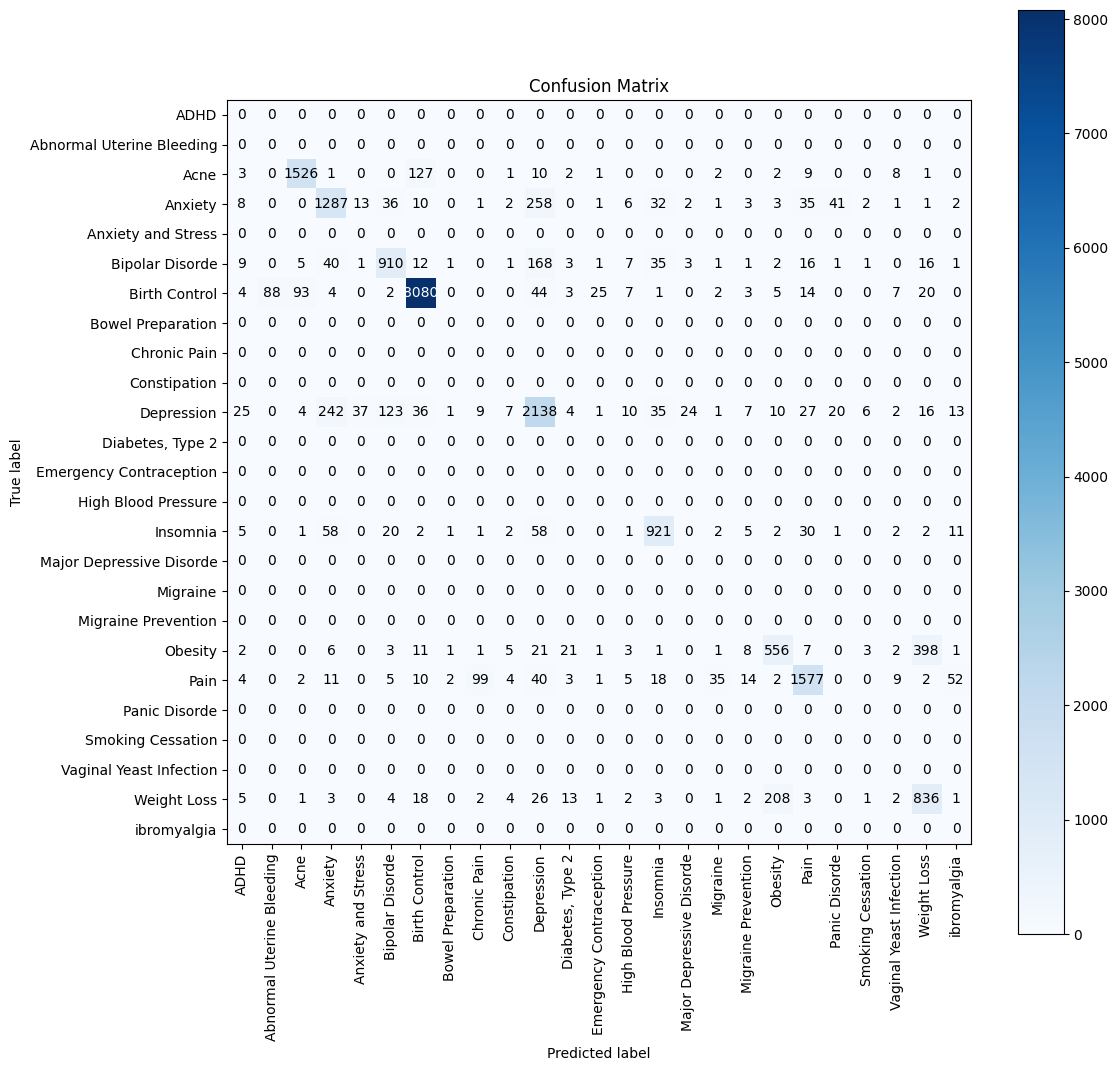

In [36]:
!pip install -U scikit-plot
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

In [37]:
def predict_single(x):    
    # lower the text
    x = x.lower()
    # Clean the text
    x =  clean_text(x)
    # Clean numbers
    x =  clean_numbers(x)
    # Clean Contractions
    x = replace_contractions(x)


    x = remove_stopwords(x)

    x = symbol_pattern.sub(' ', x)

    # tokenize
    x = tokenizer.texts_to_sequences([x])
    # pad
    x = pad_sequences(x, maxlen=maxlen)
    # create dataset
    x = torch.tensor(x, dtype=torch.long).cuda()

    pred = model(x).detach()
    pred = F.softmax(pred).cpu().numpy()

    pred = pred.argmax(axis=1)

    pred = le.classes_[pred]
    return pred[0]

In [38]:
x = data1['review'].values[0]
print(x)

son halfway fourth week intuniv became concerned began last week started taking highest dose two days could hardly get bed cranky slept nearly 8 hours drive home school vacation unusual called doctor monday morning said stick days see school getting morning last two days problem free much agreeable ever less emotional good thing less cranky remembering things overall behavior better tried many different medications far effective


In [39]:
fin_file = [] 
for i in range(len(data2)):
  x = data2['review'].values[i]
  fin_file.append([x,predict_single(x)])

<ipython-input-37-55d01d81ea8e>:24: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



In [40]:
df = pd.DataFrame(fin_file, columns=['review', 'predicted_condition'])
df.head()

,review,predicted_condition
0,"""i&#039;ve tried a few antidepressants over th...",Depression
1,"""contrave combines drugs that were used for al...",Obesity
2,"""i have been on this birth control for one cyc...",Birth Control
3,"""i&#039;ve had the copper coil for about 3 mon...",Birth Control
4,"""i was on this pill for almost two years. it d...",Birth Control


In [41]:
final_predicted_test = data2.merge(df, how = 'left', on = 'review')

In [42]:
final_predicted_test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,len,predicted_condition
0,163740,Mirtazapine,Depression,"""i&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22,439,Depression
1,39293,Contrave,Weight Loss,"""contrave combines drugs that were used for al...",9,5-Mar-17,35,782,Obesity
2,97768,Cyclafem 1 / 35,Birth Control,"""i have been on this birth control for one cyc...",9,22-Oct-15,4,762,Birth Control
3,215892,Copper,Birth Control,"""i&#039;ve had the copper coil for about 3 mon...",6,6-Jun-16,1,621,Birth Control
4,71428,Levora,Birth Control,"""i was on this pill for almost two years. it d...",2,16-Apr-11,3,470,Birth Control


In [43]:
final_predicted_test.shape

(21083, 9)

### Sentiment Analysis

In [44]:
# ALL imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style; style.use('ggplot')
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [45]:
nltk.downloader.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [46]:
# Create list (cast to array) of compound polarity sentiment scores for reviews
sentiments = []

for i in final_predicted_test.review:
  sentiments.append(sid.polarity_scores(i).get('compound'))
    #  sentiments.append(1)
    #else:
    #  sentiments.append(0)
    
    
sentiments = np.asarray(sentiments)

In [47]:
sentiments

array([-0.4596,  0.7086,  0.9559, ...,  0.9223, -0.9589, -0.926 ])

In [48]:
final_predicted_test['sentiment'] = pd.Series(data=sentiments)
final_predicted_test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,len,predicted_condition,sentiment
0,163740,Mirtazapine,Depression,"""i&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22,439,Depression,-0.4596
1,39293,Contrave,Weight Loss,"""contrave combines drugs that were used for al...",9,5-Mar-17,35,782,Obesity,0.7086
2,97768,Cyclafem 1 / 35,Birth Control,"""i have been on this birth control for one cyc...",9,22-Oct-15,4,762,Birth Control,0.9559
3,215892,Copper,Birth Control,"""i&#039;ve had the copper coil for about 3 mon...",6,6-Jun-16,1,621,Birth Control,-0.5998
4,71428,Levora,Birth Control,"""i was on this pill for almost two years. it d...",2,16-Apr-11,3,470,Birth Control,-0.8901


### Rank Ordering Drugs

In [49]:
rank_order = final_predicted_test[['condition','drugName', 'sentiment']].groupby(['condition', 'drugName']).aggregate({'sentiment':'mean'}).reset_index().sort_values(['condition', 'drugName', 'sentiment'])
rank_order.head()

,condition,drugName,sentiment
0,Acne,Absorica,0.065450
1,Acne,Acanya,0.133043
2,Acne,Accutane,0.154512
3,Acne,Acnex,0.025800
4,Acne,Aczone,0.422959


In [50]:
# from google.colab import files

# rank_order.to_csv('output.csv', encoding = 'utf-8-sig') 
# files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>